# Inteligencia Articificial Avanzada
# Segunda entrega





### Ejecutar uno de los 3 modelos y el de los gráficos

### Primer intento con PyTorch (No ejecutar)

In [ ]:
'''
# Primera versión con todo el dataset.
# Esto es simplemente para ver que corra. No hace ni separación entre entrenamiento y testeo
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

# Transformaciones para preprocesar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descargar y cargar el dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

# Definir un modelo Feedforward simple
class FeedforwardNet(nn.Module):
    def __init__(self):
        super(FeedforwardNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 10)

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicializar el modelo
net = FeedforwardNet()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

# Entrenamiento del modelo
for epoch in range(10):
    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader)}')

print('Entrenamiento finalizado!')
'''

Files already downloaded and verified
Epoch 1, Loss: 2.051612351861451
Epoch 2, Loss: 1.7603317186655596
Epoch 3, Loss: 1.6381577828046305
Epoch 4, Loss: 1.5631127191321623
Epoch 5, Loss: 1.5032563814726632
Epoch 6, Loss: 1.450783946020219
Epoch 7, Loss: 1.4035567133627889
Epoch 8, Loss: 1.3596471381919157
Epoch 9, Loss: 1.317712705001197
Epoch 10, Loss: 1.2800419948747397
Entrenamiento finalizado!


### Modelo 1 - Feed Fordward


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones para preprocesar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descargar y cargar el dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Definir una lista de las clases que queremos mantener: auto, barco y camión
classes_to_keep = ['automobile', 'ship', 'truck']

# Crear un nuevo dataset solo con las clases seleccionadas
filtered_trainset = [(img, label) for img, label in trainset if trainset.classes[label] in classes_to_keep]

# Mapear las etiquetas a índices (0, 1, 2)
class_to_idx = {cls: idx for idx, cls in enumerate(classes_to_keep)}
filtered_trainset = [(img, class_to_idx[trainset.classes[label]]) for img, label in filtered_trainset]

# Divide el conjunto de datos en entrenamiento (75%%) y validación (25%)
trainset, valset = train_test_split(filtered_trainset, test_size=0.25, random_state=42)

# Crea DataLoaders separados para entrenamiento y validación
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Definir un modelo Feedforward simple
class FeedforwardNet(nn.Module):
    def __init__(self):
        super(FeedforwardNet, self).__init__()
        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, len(classes_to_keep))
        # Salida igual al número de clases seleccionadas

    def forward(self, x):
        x = x.view(-1, 32 * 32 * 3)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Inicializar el modelo
net = FeedforwardNet()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

best_val_loss = float('inf')  # Inicializa la mejor pérdida en validación con un valor alto
early_stop_counter = 0  # Inicializa un contador para el early stopping

# Métricas de entrenamiento y validación
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Función para calcular las predicciones en el conjunto de validación
def get_predictions(net, dataloader):
    all_labels = []
    all_preds = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Entrenamiento del modelo
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_loss_history.append(running_loss / len(trainloader))
    train_accuracy_history.append(accuracy)

    # Validación
    val_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_loss_history.append(val_loss / len(valloader))
    val_accuracy_history.append(accuracy)

    # Comprueba si la pérdida en validación mejoró
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    # Si no hubo mejoras en n épocas, para de entrenar
    n = 3
    if early_stop_counter >= n:
        print('Early stopping. Fin del entrenamiento.')
        break

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}')

print('Finished Training')

# Imprimir las métricas finales
print(f'Final Training Loss: {train_loss_history[-1]:.4f}, Final Training Accuracy: {train_accuracy_history[-1]:.2f}')
print(f'Final Validation Loss: {val_loss_history[-1]:.4f}, Final Validation Accuracy: {val_accuracy_history[-1]:.2f}')

# Obtener las predicciones en el conjunto de validación
val_true_labels, val_predictions = get_predictions(net, valloader)

# Calcular la matriz de confusión para el conjunto de validación
val_confusion_matrix = confusion_matrix(val_true_labels, val_predictions)

# Calcular la matriz de confusión para el conjunto de entrenamiento
train_true_labels, train_predictions = get_predictions(net, trainloader)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predictions)

# Imprimir las matrices de confusión
print("Matriz de Confusión para el Conjunto de Entrenamiento:")
print(train_confusion_matrix)
print("\nMatriz de Confusión para el Conjunto de Validación:")
print(val_confusion_matrix)

Files already downloaded and verified
Epoch 1, Loss: 1.0102, Accuracy: 56.99
Epoch 2, Loss: 0.8699, Accuracy: 61.73
Epoch 3, Loss: 0.8068, Accuracy: 65.23
Epoch 4, Loss: 0.7657, Accuracy: 66.67
Epoch 5, Loss: 0.7312, Accuracy: 66.91
Epoch 6, Loss: 0.7003, Accuracy: 68.43
Epoch 7, Loss: 0.6710, Accuracy: 69.92
Epoch 8, Loss: 0.6461, Accuracy: 71.09
Epoch 9, Loss: 0.6214, Accuracy: 71.92
Epoch 10, Loss: 0.5966, Accuracy: 73.04
Epoch 11, Loss: 0.5741, Accuracy: 71.95
Epoch 12, Loss: 0.5532, Accuracy: 72.96
Epoch 13, Loss: 0.5350, Accuracy: 73.07
Epoch 14, Loss: 0.5151, Accuracy: 73.60
Epoch 15, Loss: 0.4943, Accuracy: 74.64
Epoch 16, Loss: 0.4741, Accuracy: 73.76
Epoch 17, Loss: 0.4523, Accuracy: 74.27
Epoch 18, Loss: 0.4322, Accuracy: 74.72
Epoch 19, Loss: 0.4097, Accuracy: 74.40
Epoch 20, Loss: 0.3974, Accuracy: 75.07
Finished Training
Final Training Loss: 0.3974, Final Training Accuracy: 85.38
Final Validation Loss: 0.6346, Final Validation Accuracy: 75.07
Matriz de Confusión para el C

### Modelo 2 - CNN (En la primera entrega usamos Keras)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

# Transformaciones para preprocesar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descargar y cargar el dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Definir una lista de las clases que queremos mantener: auto, barco y camión
classes_to_keep = ['automobile', 'ship', 'truck']

# Crear un nuevo dataset solo con las clases seleccionadas
filtered_trainset = [(img, label) for img, label in trainset if trainset.classes[label] in classes_to_keep]

# Mapear las etiquetas a índices (0, 1, 2)
class_to_idx = {cls: idx for idx, cls in enumerate(classes_to_keep)}
filtered_trainset = [(img, class_to_idx[trainset.classes[label]]) for img, label in filtered_trainset]

# Divide el conjunto de datos en entrenamiento (75%) y validación (25%)
trainset, valset = train_test_split(filtered_trainset, test_size=0.25, random_state=42)

# Crea DataLoaders separados para entrenamiento y validación
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Definir una CNN simple
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(64 * 16 * 16, 128)
        self.fc2 = nn.Linear(128, len(classes_to_keep))

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = x.view(-1, 64 * 16 * 16)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

# Inicializar el modelo CNN
net = CNN()

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

best_val_loss = float('inf')  # Inicializa la mejor pérdida en validación con un valor alto
early_stop_counter = 0  # Inicializa un contador para el early stopping

# Métricas de entrenamiento y validación
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Función para calcular las predicciones en el conjunto de validación
def get_predictions(net, dataloader):
    all_labels = []
    all_preds = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Entrenamiento del modelo
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_loss_history.append(running_loss / len(trainloader))
    train_accuracy_history.append(accuracy)

    # Validación
    val_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_loss_history.append(val_loss / len(valloader))
    val_accuracy_history.append(accuracy)

    # Comprueba si la pérdida en validación mejoró
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    # Si no hubo mejoras en n épocas, para de entrenar
    n = 3
    if early_stop_counter >= n:
        print('Early stopping. Fin del entrenamiento.')
        break

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}')

print('Finished Training')

# Imprimir las métricas finales
print(f'Final Training Loss: {train_loss_history[-1]:.4f}, Final Training Accuracy: {train_accuracy_history[-1]:.2f}')
print(f'Final Validation Loss: {val_loss_history[-1]:.4f}, Final Validation Accuracy: {val_accuracy_history[-1]:.2f}')

# Obtener las predicciones en el conjunto de validación
val_true_labels, val_predictions = get_predictions(net, valloader)

# Calcular la matriz de confusión para el conjunto de validación
val_confusion_matrix = confusion_matrix(val_true_labels, val_predictions)

# Calcular la matriz de confusión para el conjunto de entrenamiento
train_true_labels, train_predictions = get_predictions(net, trainloader)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predictions)

# Imprimir las matrices de confusión
print("Matriz de Confusión para el Conjunto de Entrenamiento:")
print(train_confusion_matrix)
print("\nMatriz de Confusión para el Conjunto de Validación:")
print(val_confusion_matrix)

Files already downloaded and verified
Epoch 1, Loss: 0.8932, Accuracy: 62.53
Epoch 2, Loss: 0.7494, Accuracy: 69.15
Epoch 3, Loss: 0.6778, Accuracy: 72.48
Epoch 4, Loss: 0.6213, Accuracy: 71.95
Epoch 5, Loss: 0.5802, Accuracy: 75.09
Epoch 6, Loss: 0.5447, Accuracy: 76.16
Epoch 7, Loss: 0.5163, Accuracy: 77.65
Epoch 8, Loss: 0.4855, Accuracy: 77.57
Epoch 9, Loss: 0.4703, Accuracy: 79.65
Epoch 10, Loss: 0.4424, Accuracy: 78.69
Epoch 11, Loss: 0.4273, Accuracy: 80.75
Epoch 12, Loss: 0.4093, Accuracy: 81.20
Epoch 13, Loss: 0.3969, Accuracy: 81.31
Epoch 14, Loss: 0.3799, Accuracy: 81.23
Epoch 15, Loss: 0.3710, Accuracy: 80.29
Epoch 16, Loss: 0.3550, Accuracy: 82.08
Epoch 17, Loss: 0.3462, Accuracy: 81.79
Epoch 18, Loss: 0.3389, Accuracy: 82.19
Epoch 19, Loss: 0.3289, Accuracy: 82.03
Epoch 20, Loss: 0.3073, Accuracy: 82.11
Finished Training
Final Training Loss: 0.3073, Final Training Accuracy: 88.59
Final Validation Loss: 0.4557, Final Validation Accuracy: 82.11
Matriz de Confusión para el C

### Modelo 3 - ResNet - Este guarda en el drive. Después se puede ejecutar la celda de abajo

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

# Transformaciones para preprocesar los datos
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descargar y cargar el dataset CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Definir una lista de las clases que queremos mantener: auto, barco y camión
classes_to_keep = ['automobile', 'ship', 'truck']

# Crear un nuevo dataset solo con las clases seleccionadas
filtered_trainset = [(img, label) for img, label in trainset if trainset.classes[label] in classes_to_keep]

# Mapear las etiquetas a índices (0, 1, 2)
class_to_idx = {cls: idx for idx, cls in enumerate(classes_to_keep)}
filtered_trainset = [(img, class_to_idx[trainset.classes[label]]) for img, label in filtered_trainset]

# Divide el conjunto de datos en entrenamiento (75%) y validación (25%)
trainset, valset = train_test_split(filtered_trainset, test_size=0.25, random_state=42)

# Crea DataLoaders separados para entrenamiento y validación
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Definir la arquitectura ResNet-18 preentrenada
import torchvision.models as models

# Cargar la arquitectura ResNet-18 preentrenada
net = models.resnet18(pretrained=True)

# Modificar la capa de salida para tener 3 clases en lugar de 1000 (que es la cantidad original de clases en ImageNet)
num_features = net.fc.in_features
net.fc = nn.Linear(num_features, len(classes_to_keep))

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

best_val_loss = float('inf')  # Inicializa la mejor pérdida en validación con un valor alto
early_stop_counter = 0  # Inicializa un contador para el early stopping

# Métricas de entrenamiento y validación
train_loss_history = []
train_accuracy_history = []
val_loss_history = []
val_accuracy_history = []

# Función para calcular las predicciones en el conjunto de validación
def get_predictions(net, dataloader):
    all_labels = []
    all_preds = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Entrenamiento del modelo
for epoch in range(20):
    running_loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    train_loss_history.append(running_loss / len(trainloader))
    train_accuracy_history.append(accuracy)

    # Validación
    val_loss = 0.0
    correct = 0
    total = 0
    net.eval()
    with torch.no_grad():
        for data in valloader:
            inputs, labels = data
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    val_loss_history.append(val_loss / len(valloader))
    val_accuracy_history.append(accuracy)

    # Comprueba si la pérdida en validación mejoró
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
    else:
        early_stop_counter += 1

    # Si no hubo mejoras en n épocas, para de entrenar
    n = 3
    if early_stop_counter >= n:
        print('Early stopping. Fin del entrenamiento.')
        break

    print(f'Epoch {epoch + 1}, Loss: {running_loss / len(trainloader):.4f}, Accuracy: {accuracy:.2f}')

print('Finished Training')

# Imprimir las métricas finales
print(f'Final Training Loss: {train_loss_history[-1]:.4f}, Final Training Accuracy: {train_accuracy_history[-1]:.2f}')
print(f'Final Validation Loss: {val_loss_history[-1]:.4f}, Final Validation Accuracy: {val_accuracy_history[-1]:.2f}')

# Obtener las predicciones en el conjunto de validación
val_true_labels, val_predictions = get_predictions(net, valloader)

# Calcular la matriz de confusión para el conjunto de validación
val_confusion_matrix = confusion_matrix(val_true_labels, val_predictions)

# Calcular la matriz de confusión para el conjunto de entrenamiento
train_true_labels, train_predictions = get_predictions(net, trainloader)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predictions)

# Imprimir las matrices de confusión
print("Matriz de Confusión para el Conjunto de Entrenamiento:")
print(train_confusion_matrix)
print("\nMatriz de Confusión para el Conjunto de Validación:")
print(val_confusion_matrix)
torch.save(net.state_dict(), '/content/drive/MyDrive/resnet_entrenado.pth')

import pickle

# Crea un diccionario que contenga todas las variables
# Guardo todo por que al cargar después lo puedo necesitar
variables = {
    'trainloader': trainloader,
    'valloader': valloader,
    'net': net,
    'optimizer': optimizer,
    'train_loss_history': train_loss_history,
    'train_accuracy_history': train_accuracy_history,
    'val_loss_history': val_loss_history,
    'val_accuracy_history': val_accuracy_history,
    'best_val_loss': best_val_loss,
    'early_stop_counter': early_stop_counter,
    'train_confusion_matrix': train_confusion_matrix,
    'val_confusion_matrix': val_confusion_matrix
}

# Guarda el diccionario en un archivo pickle
with open('/content/drive/MyDrive/resnet_entrenado_variables.pkl', 'wb') as file:
    pickle.dump(variables, file)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified
Epoch 1, Loss: 0.6102, Accuracy: 84.85
Epoch 2, Loss: 0.3056, Accuracy: 88.91
Epoch 3, Loss: 0.2173, Accuracy: 89.68
Epoch 4, Loss: 0.1526, Accuracy: 90.45
Epoch 5, Loss: 0.1008, Accuracy: 90.40
Epoch 6, Loss: 0.0791, Accuracy: 89.31
Early stopping. Fin del entrenamiento.
Finished Training
Final Training Loss: 0.0504, Final Training Accuracy: 98.14
Final Validation Loss: 0.3815, Final Validation Accuracy: 90.37
Matriz de Confusión para el Conjunto de Entrenamiento:
[[3573    2  101]
 [  57 3691   83]
 [  29    3 3711]]

Matriz de Confusión para el Conjunto de Validación:
[[1178   23  123]
 [  59 1057   53]
 [  85   18 1154]]


### Modelo 3 - ResNet - Carga de modelo previamente guardado arriba

In [1]:
import torch
import torch.nn as nn
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import numpy as np

from google.colab import drive
drive.mount('/content/drive')

import pickle

# Carga el diccionario desde el archivo pickle
with open('/content/drive/MyDrive/resnet_entrenado_variables.pkl', 'rb') as file:
    variables = pickle.load(file)

# Ahora, puedes acceder a tus variables como lo hacías antes
trainloader = variables['trainloader']
valloader = variables['valloader']
net = variables['net']
optimizer = variables['optimizer']
train_loss_history = variables['train_loss_history']
train_accuracy_history = variables['train_accuracy_history']
val_loss_history = variables['val_loss_history']
val_accuracy_history = variables['val_accuracy_history']
best_val_loss = variables['best_val_loss']
early_stop_counter = variables['early_stop_counter']
train_confusion_matrix = variables['train_confusion_matrix']
val_confusion_matrix = variables['val_confusion_matrix']


# Definir las transformaciones para preprocesar los datos
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Descargar y cargar el conjunto de datos CIFAR-10
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Definir una lista de las clases que queremos mantener: auto, barco y camión
classes_to_keep = ['automobile', 'ship', 'truck']

# Crear un nuevo conjunto de datos solo con las clases seleccionadas
filtered_trainset = [(img, label) for img, label in trainset if trainset.classes[label] in classes_to_keep]

# Mapear las etiquetas a índices (0, 1, 2)
class_to_idx = {cls: idx for idx, cls in enumerate(classes_to_keep)}
filtered_trainset = [(img, class_to_idx[trainset.classes[label]]) for img, label in filtered_trainset]

# Dividir el conjunto de datos en entrenamiento (75%) y validación (25%)
trainset, valset = train_test_split(filtered_trainset, test_size=0.25, random_state=42)
# Misma división que antes

# Crear DataLoaders separados para entrenamiento y validación
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Crear un modelo ResNet-18 sin pesos preentrenados
net = torchvision.models.resnet18(pretrained=False)
net.fc = nn.Linear(net.fc.in_features, len(classes_to_keep))

# Cargar el modelo entrenado
net.load_state_dict(torch.load('/content/drive/MyDrive/resnet_entrenado.pth'))
net.eval()  # Establecer el modelo en modo de evaluación

# Función para calcular las predicciones en el conjunto de validación
def get_predictions(net, dataloader):
    all_labels = []
    all_preds = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(predicted.cpu().numpy())
    return np.array(all_labels), np.array(all_preds)

# Obtener las predicciones en el conjunto de validación
val_true_labels, val_predictions = get_predictions(net, valloader)

# Calcular la matriz de confusión para el conjunto de validación
val_confusion_matrix = confusion_matrix(val_true_labels, val_predictions)

# Calcular la matriz de confusión para el conjunto de entrenamiento
train_true_labels, train_predictions = get_predictions(net, trainloader)
train_confusion_matrix = confusion_matrix(train_true_labels, train_predictions)

# Imprimir las matrices de confusión
print("Matriz de Confusión para el Conjunto de Entrenamiento:")
print(train_confusion_matrix)
print("\nMatriz de Confusión para el Conjunto de Validación:")
print(val_confusion_matrix)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Matriz de Confusión para el Conjunto de Entrenamiento:
[[3573    2  101]
 [  57 3691   83]
 [  29    3 3711]]

Matriz de Confusión para el Conjunto de Validación:
[[1178   23  123]
 [  59 1057   53]
 [  85   18 1154]]


### Gráficos

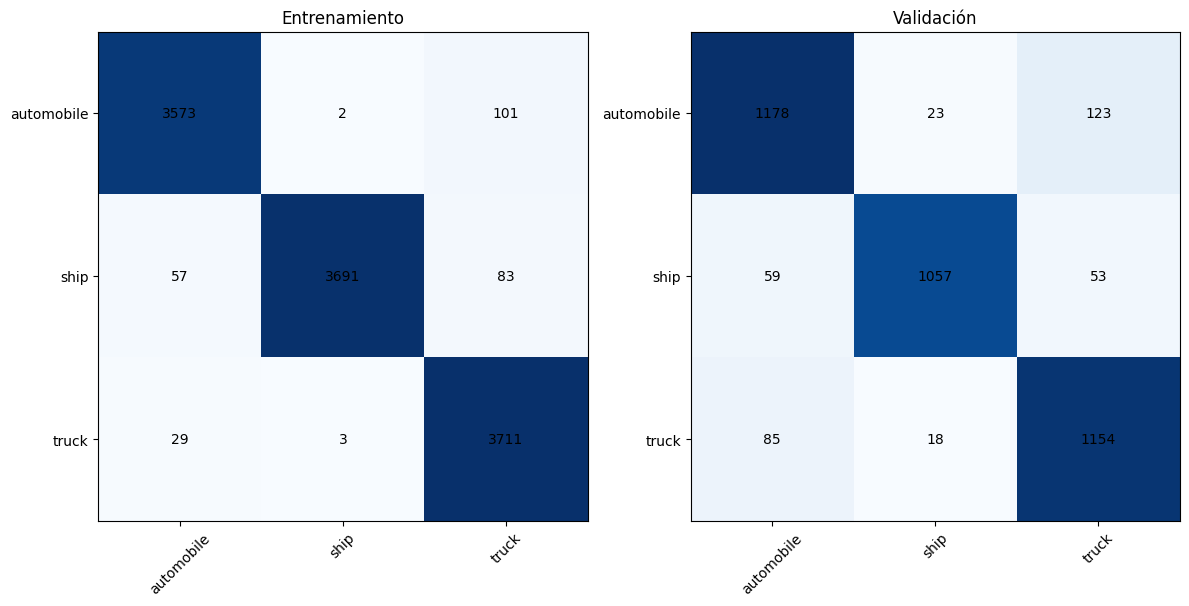

In [4]:
import matplotlib.pyplot as plt
# Visualizar las matrices de confusión
def plot_confusion_matrix(cm, classes, title):
    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(cm[0], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Entrenamiento')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[0][i][j]), ha='center', va='center', color='black')

    plt.subplot(1, 2, 2)
    plt.imshow(cm[1], interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Validación')
    plt.xticks(np.arange(len(classes)), classes, rotation=45)
    plt.yticks(np.arange(len(classes)), classes)
    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, str(cm[1][i][j]), ha='center', va='center', color='black')

    plt.tight_layout()
    plt.suptitle(title)
    plt.show()

# Clases en orden
class_names = classes_to_keep

# Graficar matrices de confusión
plot_confusion_matrix([train_confusion_matrix, val_confusion_matrix], classes=class_names, title='')

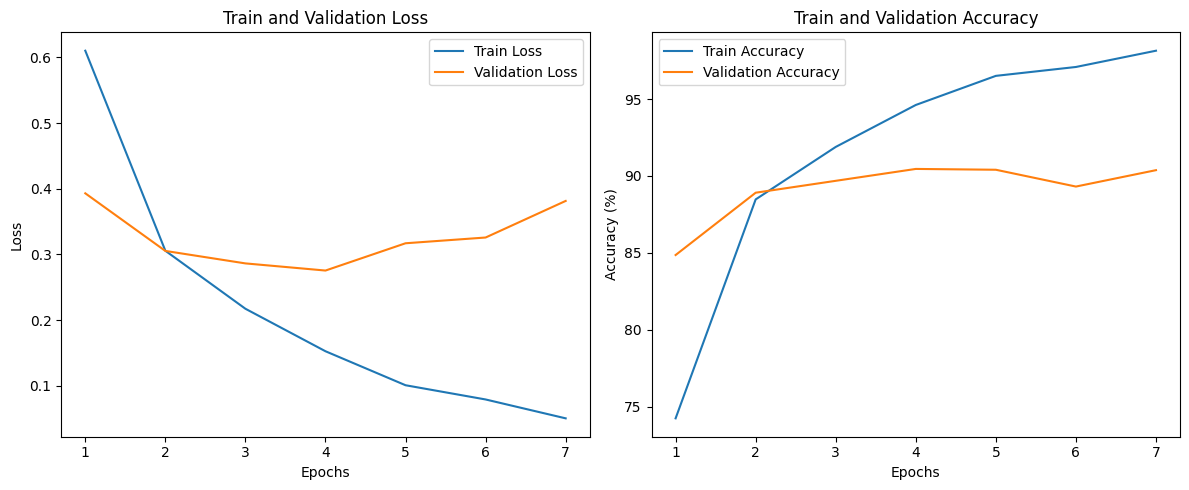

In [5]:
import matplotlib.pyplot as plt

# Crear un arreglo de épocas para el eje x
epochs = list(range(1, len(train_loss_history) + 1))

# Graficar la pérdida de entrenamiento y validación en el mismo gráfico
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss_history, label='Train Loss')
plt.plot(epochs, val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Validation Loss')
plt.legend()

# Graficar la precisión de entrenamiento y validación en el mismo gráfico
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracy_history, label='Train Accuracy')
plt.plot(epochs, val_accuracy_history, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Train and Validation Accuracy')
plt.legend()

# Mostrar el gráfico
plt.tight_layout()
plt.show()


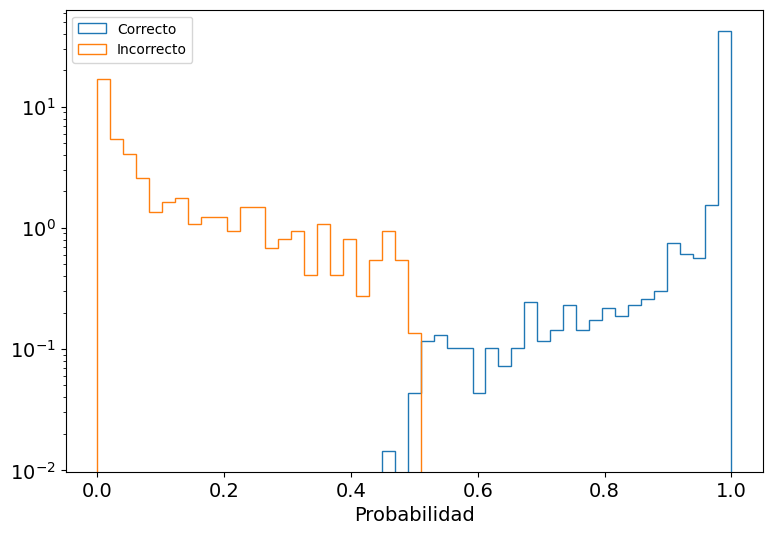

In [6]:
import matplotlib.pyplot as plt

# Función para obtener las probabilidades en el conjunto de validación
def get_probabilities(net, dataloader):
    all_probabilities = []
    net.eval()
    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            outputs = net(inputs)
            probabilities = torch.softmax(outputs, dim=1)
            all_probabilities.extend(probabilities.cpu().numpy())
    return np.array(all_probabilities)

# Obtener las probabilidades en el conjunto de validación
val_probabilities = get_probabilities(net, valloader)

# Distribución de probabilidades
fig = plt.figure(figsize=(9, 6))

# Definir los bins para el histograma
bins = np.linspace(0, 1, 50)

# Histograma de probabilidades en casos correctos
probs_correct = []
for i, (true_label, probabilities) in enumerate(zip(val_true_labels, val_probabilities)):
    if true_label == np.argmax(probabilities):
        probs_correct.append(probabilities[true_label])
probs_correct = np.array(probs_correct)
plt.hist(probs_correct, bins=bins, histtype='step', label='Correcto', density=True, log=True)

# Histograma de probabilidades en casos incorrectos
probs_incorrect = []
for i, (true_label, probabilities) in enumerate(zip(val_true_labels, val_probabilities)):
    if true_label != np.argmax(probabilities):
        probs_incorrect.append(probabilities[true_label])
probs_incorrect = np.array(probs_incorrect)
plt.hist(probs_incorrect, bins=bins, histtype='step', label='Incorrecto', density=True)

# Etiquetas y marcas
plt.xlabel('Probabilidad', size=14)
plt.gca().tick_params(axis='both', which='major', labelsize=14)

plt.legend(loc=2)
plt.show()
